In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')
matcher = spacy.matcher.Matcher(nlp.vocab)

def find_root_of_sentence(doc):
    root_tokens = []
    for token in doc:
        if token.dep_ == "ROOT" or token.dep_ == "pcomp" or token.dep_ == "prep":
            root_tokens.append(token)
    return root_tokens


verb_patterns = [
    [{"POS": "AUX"}, {"POS": "VERB"}, {"POS": "ADP"}],
    [{"POS": "AUX"}, {"POS": "ADP"}],
    [{"POS": "AUX"}, {"POS": "VERB"}, {"POS": "ADP"}],
    [{"POS": "VERB"}],
    [{"POS": "VERB"}, {"DEP": "prep"}],
    [{"DEP": "prep"}],
    [{"DEP": "amod"}]
]

def contains_root(verb_phrase, roots):
    for root in roots:
        if verb_phrase.start <= root.i <= verb_phrase.end:
            return True
    return False

def get_verb_phrases(doc):
    roots = find_root_of_sentence(doc)
    verb_phrases = []
    for pattern in verb_patterns:
        matcher.add("verb_pattern", [pattern])
        matches = matcher(doc)
        for match_id, start, end in matches:
            verb_phrase = doc[start:end]
            # Check if the verb phrase contains the root of the sentence
            if contains_root(verb_phrase, roots):
                verb_phrases.append(verb_phrase)
        matcher.remove("verb_pattern")
    return verb_phrases

def find_combinations(sentence):
    doc = nlp(sentence)
    verb_phrases = get_verb_phrases(doc)
    combinations_set = set()  # Use a set to keep track of distinct combinations

    if not verb_phrases:
        return [sentence]  # If no verb phrase found, return the whole sentence

    for verb_phrase in verb_phrases:
        left_noun_phrase = " ".join(token.text for token in doc if token.i < verb_phrase.start and token.is_alpha and token.dep_ != "nummod")
        verb_phrase_text = " ".join(token.text for token in verb_phrase)
        right_noun_phrase_tokens = [token.text for token in doc if verb_phrase.end < token.i < len(doc) - 1 and token.dep_ != "punct" and token.dep_ != "nummod"]

        if right_noun_phrase_tokens:
            right_noun_phrase = " ".join(right_noun_phrase_tokens)
        else:
            # If right noun phrase is not fully formed, take tokens after the verb
            right_noun_phrase_tokens = [token.text for token in doc if token.i > verb_phrase.start and token.dep_ != "punct" and token.dep_ != "nummod"]
            right_noun_phrase = " ".join(right_noun_phrase_tokens)

        # Filter out articles like "the" from the right noun phrase
        right_noun_phrase_tokens = [token.text for token in doc[verb_phrase.end + 1:] if token.is_alpha and token.pos_ != 'DET' and token.dep_ != "nummod"]
        if right_noun_phrase_tokens:
            right_noun_phrase = " ".join(right_noun_phrase_tokens)

        # Create combinations
        combination = f"{left_noun_phrase} -> {verb_phrase_text} -> {right_noun_phrase}"
        combinations_set.add(combination)

        # Create combinations with partial verb phrases
        if left_noun_phrase and right_noun_phrase_tokens:
            partial_combination = f"{left_noun_phrase} -> {verb_phrase_text} -> {right_noun_phrase_tokens[0]}"
            # Check if the partial combination already exists, and add it only if it's not a duplicate
            if partial_combination not in combinations_set:
                combinations_set.add(partial_combination)

    return list(combinations_set)


# Initialize an empty list to store comments
file = []

# Specify the path to your .txt file
txt_file_path = '/kaggle/input/flickr8k/captions.txt'  # Replace with the actual path to your file

# Read the .txt file and extract comments with filenames
with open(txt_file_path, 'r') as txtfile:
    for line in txtfile:
        # Split each line into parts using a comma as the delimiter
        parts = line.strip().split(',')
        if len(parts) >= 2:
            # Assuming that comments are in the third part and filename is the last part
            comment = parts[1]
            filename = parts[0]  # Extracting the filename
            file.append((comment, filename))
            

# Now 'file' contains tuples of comments and their respective filenames
# You can print or process them as needed
for i, (comment, filename) in enumerate(file, 1):
    #print(f"{filename}): \"{comment}\"\n")
    combinations = find_combinations(comment)
    #if combinations:
    #    print("Combinations:")
    #    for combo in combinations:
    #        print(combo)
    #else:
    #    print("No combinations found.")
    #print()


In [ ]:
# Specify the path to your output CSV file
output_csv_path = 'output_combinations.csv'

with open(output_csv_path, 'w') as output_file:
    # Write the header to the CSV file
    output_file.write("subject,relationship,object,filename\n")

    for i, (comment, filename) in enumerate(file, 1):
        combinations = find_combinations(comment)
        for combo in combinations:
            # Assuming the combinations are formatted as "subject -> relationship -> object"
            parts = combo.split(" -> ")
            if len(parts) == 3:
                # Write the subject, relationship, object, and filename to the CSV file
                output_file.write(f"{parts[0]},{parts[1]},{parts[2]},{filename}\n")


In [ ]:
# Specify the path to your output CSV file
output_csv_path = '/kaggle/working/output_combinations.csv'

# Read and print the contents of the CSV file
with open(output_csv_path, 'r') as output_file:
    contents = output_file.read()
    num_lines = contents.count('\n') + 1  # Add 1 to account for the last line

print(f'The CSV file has {num_lines} lines.')
   # print(contents)


In [ ]:
!pip install rdflib


In [ ]:
import csv
from rdflib import Graph, Namespace, RDF
csv.field_size_limit(100 * 1024 * 1024)  # For example, setting a limit to 10 MB

# Create an RDF graph
g = Graph()

# Define Namespaces
ex = Namespace("Relationship:")

# Read data from a CSV file
csv_file_path = '/kaggle/working/output_combinations.csv'  # Replace with your CSV file path

with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader)  # Skip header if present
    for row in csv_reader:
        if len(row) >= 4:
            subj, rel, obj, filename = row[:4]  # Assuming the first 4 columns contain subject, relationship, object, and filename
            # Replace spaces in subjects, objects, and relationships with underscores
            subj = subj.replace(" ", "_")
            rel = rel.replace(" ", "_")
            obj = obj.replace(" ", "_")

# Then create the RDF triples with the modified URIs
            # Add triples to the graph

            g.add((ex[subj], ex['presentin'], ex[filename]))
            g.add((ex[subj], ex['linked'], ex[rel]))
            g.add((ex[rel], ex['existsfor'], ex[obj]))
            g.add((ex[rel], ex['foundin'], ex[filename]))

# Serialize the graph into a file (Turtle format)
g.serialize(destination='graph_data.ttl', format='turtle')


In [ ]:
import csv
from rdflib import Graph, Namespace

# Load the RDF data if it exists
existing_graph = Graph()
existing_graph.parse("graph_data.ttl", format="turtle")

# Define Namespaces
ex = Namespace("Relationship:")

# Execute SPARQL queries on the existing graph
query1 = """
PREFIX ex: <Relationship:>
SELECT ?object ?filename
WHERE {
  ?object ex:presentIn ?filename.
}
"""

query2 = """
PREFIX ex: <Relationship:>
SELECT ?object ?relationship
WHERE {
  ?object ex:linked ?relationship.
}
"""

query3 = """
PREFIX ex: <Relationship:>
SELECT ?relationship ?object
WHERE {
  ?relationship ex:presentin ?object.
}
"""

query4 = """
PREFIX ex: <Relationship:>
SELECT ?relationship ?filename
WHERE {
  ?relationship ex:foundIn ?filename.
}
"""


In [ ]:
!pip install --upgrade networkx
!pip install --upgrade scipy


In [ ]:
import networkx as nx
import scipy

print("NetworkX version:", nx.__version__)
print("SciPy version:", scipy.__version__)

In [ ]:
from rdflib import Graph
import networkx as nx
import matplotlib.pyplot as plt

# Load the RDF data
g = Graph()
g.parse("graph_data.ttl", format="turtle")

# Convert RDF graph to NetworkX DiGraph
g_nx = nx.DiGraph()

for s, p, o in g:
    g_nx.add_node(s)
    g_nx.add_node(o)
    g_nx.add_edge(s, o, label=p)

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.shell_layout(g_nx)
nx.draw(g_nx, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(g_nx, 'label')
nx.draw_networkx_edge_labels(g_nx, pos, edge_labels=edge_labels)
plt.show()


In [ ]:
from rdflib import Graph, Namespace

# Load the RDF data if it exists
existing_graph = Graph()
existing_graph.parse("graph_data.ttl", format="turtle")

# Define Namespace
ex = Namespace("Relationship:")

# Execute SPARQL queries on the existing graph
query_text_image = """
PREFIX ex: <Relationship:>
SELECT ?text ?filename
WHERE {
  ?text ex:presentin ?filename.
}
"""

query_image_text = """
PREFIX ex: <Relationship:>
SELECT ?filename ?text
WHERE {
  ?text ex:presentin ?filename.
}
"""

# Retrieve knowledge base texts and image names
knowledge_base_texts = []
image_names = []

# Retrieving texts associated with image names
query_result_text_image = existing_graph.query(query_text_image)
for row in query_result_text_image:
    knowledge_base_texts.append(str(row[0]))
    image_names.append(str(row[1]))

# Printing extracted data for knowledge_base_texts and image_names
#print("Knowledge Base Texts:")
#print(knowledge_base_texts)
#print("\nImage Names:")
#print(image_names)

In [ ]:
import json

# Store data in a dictionary
data = {
    "knowledge_base_texts": knowledge_base_texts,
    "image_names": image_names
}

# Define the filename for saving the JSON
output_filename = "/kaggle/working/knowledge_base_data.json"

# Save the data as JSON
with open(output_filename, "w") as json_file:
    json.dump(data, json_file)

print(f"Saved knowledge base data to {output_filename}")


In [1]:
import json

# Define the filename where the knowledge base data is stored
input_filename = "/kaggle/input/8kdataset/knowledge_base_data (1).json"

# Load the data from the JSON file
with open(input_filename, "r") as json_file:
    loaded_data = json.load(json_file)

# Access the loaded data
knowledge_base_texts = loaded_data["knowledge_base_texts"]
image_names = loaded_data["image_names"]

# Now you can use the loaded data as needed
# For example, printing the first few elements
print("Knowledge Base Texts:")
print(knowledge_base_texts[:5])  # Print the first 5 texts
print("\nImage Names:")
print(image_names[:5])  # Print the first 5 image names


Knowledge Base Texts:
['Relationship:ATV_racers', 'Relationship:ATV_racers_coming', 'Relationship:A_couple', 'Relationship:A_couple_of_people_are', 'Relationship:A_couple_of_people_are_riding_ATV']

Image Names:
['Relationship:3458215674_2aa5e64643.jpg', 'Relationship:3458215674_2aa5e64643.jpg', 'Relationship:3458215674_2aa5e64643.jpg', 'Relationship:3458215674_2aa5e64643.jpg', 'Relationship:3458215674_2aa5e64643.jpg']


/kaggle/input/flickr8k/Images/1057089366_ca83da0877.jpg"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


94765736/94765736 [==============================] - 1s 0us/step


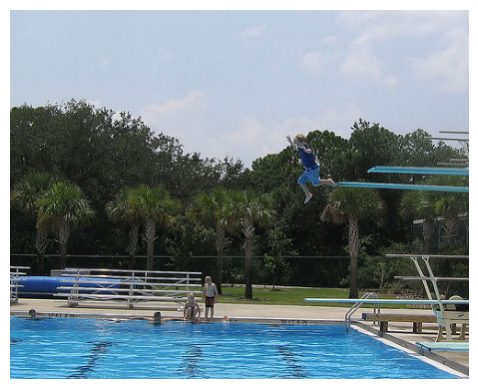

1/1 [==============================] - 3s 3s/step
Generated Caption: A boy jumps into a pool .


In [2]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt

# Load the ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

# Load the pre-trained captioning model
caption_model = load_model('/kaggle/input/models-final-79/my_model.h5')

# Function to preprocess the image and extract ResNet50 features
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to generate captions using the loaded models
def generate_captions(img_path, resnet_model, caption_model, word_to_index, index_to_word):
    in_text = '<start>'
    max_length = 40
    photo = preprocess_image(img_path)
    
    # Extract features using ResNet50
    features = resnet_model.predict(photo)
    
    for _ in range(max_length):
        sequence = [word_to_index[word] for word in in_text.split() if word in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = caption_model.predict([features, sequence], verbose=0)
        y_pred = np.argmax(y_pred[0])
        word = index_to_word[y_pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()[1:-1]
    sentence = ' '.join(final)
    return sentence

# Example usage: Provide the path to your image
#image_path = "/kaggle/input/flickr8k/Images/1057089366_ca83da0877.jpg"
image_path = "/kaggle/input/testing/Screenshot from 2024-02-19 20-00-55.png"
# Display the image
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
# Load word-to-index and index-to-word mappings
with open("/kaggle/input/indices/words_to_indices.pickle", "rb") as file:
    word_to_index = pickle.load(file)
with open("/kaggle/input/indices/indices_to_words.pickle", "rb") as file:
    index_to_word = pickle.load(file)

# Generate captions for the image
generated_caption = generate_captions(image_path, resnet_model, caption_model, word_to_index, index_to_word)
print("Generated Caption:", generated_caption)


In [54]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance

# Preprocess knowledge_base_texts
processed_texts = [text.split(':')[-1].replace('_', ' ') for text in knowledge_base_texts]

# Calculate Jenson-Shannon divergence
def calculate_jenson_shannon_similarity(input_text, knowledge_base_texts):
    vectorizer = TfidfVectorizer()
    
    # Fit and transform the input text and knowledge_base_texts
    tfidf_matrix = vectorizer.fit_transform([input_text] + knowledge_base_texts)
    
    # Convert the TF-IDF matrix to probability distributions
    input_distribution = tfidf_matrix[0].toarray().flatten()
    knowledge_base_distributions = tfidf_matrix[1:].toarray()

    # Smooth the distributions
    input_distribution = (input_distribution + 1e-10) / np.sum(input_distribution + 1e-10)
    knowledge_base_distributions = (knowledge_base_distributions + 1e-10) / np.sum(knowledge_base_distributions + 1e-10, axis=1, keepdims=True)

    # Calculate Jenson-Shannon divergence
    js_similarities = np.array([1 - distance.jensenshannon(input_distribution, dist) for dist in knowledge_base_distributions])

    return js_similarities

# Input text for comparison
input_text = generated_caption

# Calculate Jenson-Shannon similarity using processed_texts
js_similarity_scores = calculate_jenson_shannon_similarity(input_text, processed_texts)
print("Jenson-Shannon Similarity:", js_similarity_scores)


Jenson-Shannon Similarity: [0.16744555 0.16744554 0.16744558 ... 0.16744553 0.16744558 0.16900652]


In [55]:

import numpy as np

# Assuming you have image_names and js_similarity_scores defined earlier

# Use numpy to get top similar indices
top_similar_indices = np.argsort(js_similarity_scores)[::-1]

# Keep track of selected images
selected_images = set()

# Retrieve top unique similar image names
top_unique_similar_images = []
for idx in top_similar_indices:
    if idx < len(image_names):
        img = image_names[idx]
        similarity_score = js_similarity_scores[idx]

        # Check if the image is not already selected
        if img not in selected_images:
            top_unique_similar_images.append((img, similarity_score))
            selected_images.add(img)

        # Break the loop if we have collected 5 unique images
        if len(top_unique_similar_images) == 5:
            break

# Display top unique similar image names with similarity scores
print("Top unique similar image names with similarity scores:")
for img, similarity_score in top_unique_similar_images:
    print(f"{img} - Similarity Score: {similarity_score}")



Top unique similar image names with similarity scores:
Relationship:2461616306_3ee7ac1b4b.jpg - Similarity Score: 1.0
Relationship:3567604049_da9e1be4ba.jpg - Similarity Score: 0.7684211746374895
Relationship:2501595799_6316001e89.jpg - Similarity Score: 0.6721103599171236
Relationship:1236951314_0308dc4138.jpg - Similarity Score: 0.6457555106327257
Relationship:1288909046_d2b2b62607.jpg - Similarity Score: 0.5831343053215015


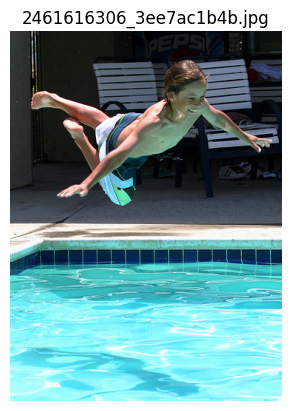

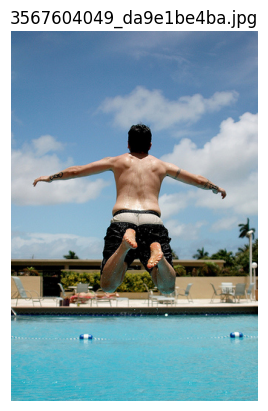

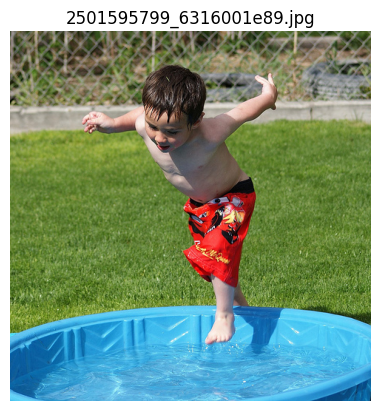

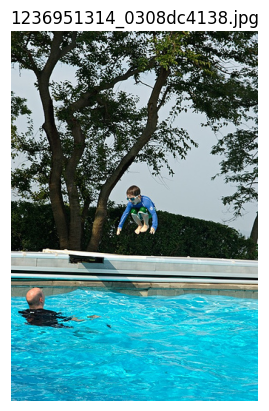

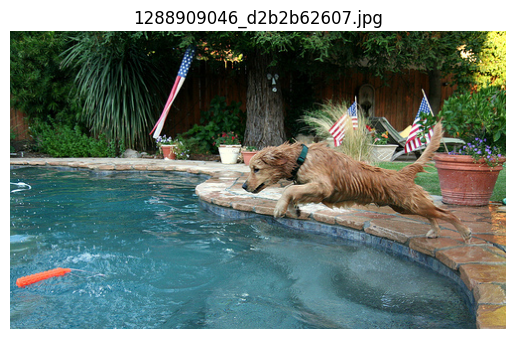

In [56]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have a directory path where your images are stored
images_directory = '/kaggle/input/flickr8k/Images/'  # Replace with your directory path

# Create a list of image names with the format 'name.jpg'
filtered_top_images = [name[0].split(':')[-1]  for name in top_unique_similar_images]

# Load and display top similar images
for img_file in filtered_top_images:
    img_path = images_directory + img_file
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')  # Hide axes
    plt.show()


x

1
1.0
2
1.0
4
1.0
6
1.0
8
1.0
10
1.0


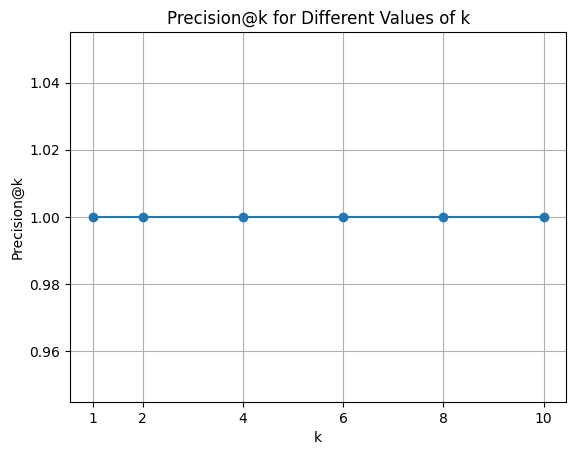

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define the threshold for considering a similarity score as relevant
threshold = 0.3

# Sort the similarity scores in descending order
sorted_indices = np.argsort(js_similarity_scores)[::-1]
sorted_similarity_scores = js_similarity_scores[sorted_indices]

# Adjust ground truth relevance based on the sorted similarity scores
ground_truth_relevance = (sorted_similarity_scores > threshold).astype(int)

# Define values of k for precision@k
ks = [1,2, 4, 6,8,10]

# Define the precision_at_k function
def precision_at_k(ground_truth_relevance, k):
    relevant_count = sum(ground_truth_relevance[:k])
    print(relevant_count)
    return relevant_count / k

# Calculate precision@k for each k
precisions = []
for k in ks:
    precision = precision_at_k(ground_truth_relevance, k)
    print(precision)
    precisions.append(precision)

# Plot precision@k
plt.plot(ks, precisions, marker='o')
plt.title('Precision@k for Different Values of k')
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.grid(True)
plt.xticks(ks)
plt.show()


import matplotlib.pyplot as plt
import os

# Define the directory containing the images
image_directory = "/kaggle/input/flickr8k/Images"
relevant_indices = []

# Iterate over the similarity scores and check if each score is greater than the threshold
for idx, score in enumerate(js_similarity_scores):
    if score > threshold:
        relevant_indices.append(idx)


# Sort relevant indices based on similarity scores
relevant_indices_sorted = sorted(relevant_indices, key=lambda idx: js_similarity_scores[idx], reverse=True)

# Function to display images
def display_images(image_names, image_directory):
    plt.figure(figsize=(15, 7))
    for i, image_name in enumerate(image_names, start=1):
        # Extract the actual image file name by removing additional text
        image_file_name = image_name.split(':')[1]
        image_path = os.path.join(image_directory, image_file_name)
        image = plt.imread(image_path)
        plt.subplot(1, len(image_names), i)
        plt.imshow(image)
        plt.title(image_file_name)
        plt.axis('off')
    plt.show()

# Display relevant images in the order of highest similarity scores
relevant_image_names_sorted = [image_names[idx] for idx in relevant_indices_sorted]
display_images(relevant_image_names_sorted, image_directory)


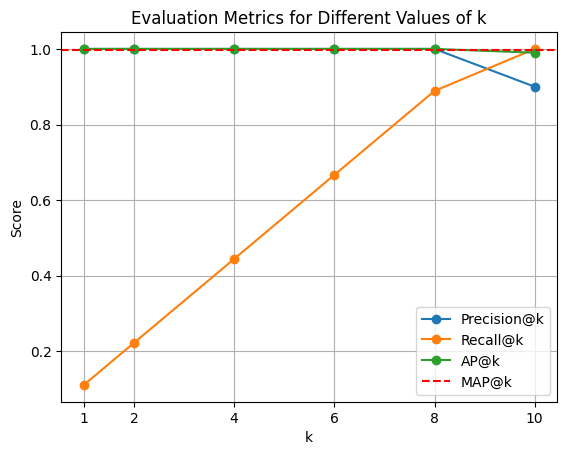

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Define the threshold for considering a similarity score as relevant
threshold = 0.5

# Sort the similarity scores in descending order
sorted_indices = np.argsort(js_similarity_scores)[::-1]
sorted_similarity_scores = js_similarity_scores[sorted_indices]

# Adjust ground truth relevance based on the sorted similarity scores
ground_truth_relevance = (sorted_similarity_scores > threshold).astype(int)

# Define values of k for evaluation metrics
ks = [1, 2, 4, 6, 8, 10]

# Define the precision_at_k function
def precision_at_k(ground_truth_relevance, k):
    relevant_count = sum(ground_truth_relevance[:k])
    return relevant_count / k

# Calculate precision@k for each k
precisions = []
for k in ks:
    precision = precision_at_k(ground_truth_relevance, k)
    precisions.append(precision)

# Calculate Recall@k for each k
recalls = []
for k in ks:
    recall = sum(ground_truth_relevance[:k]) / sum(ground_truth_relevance)
    recalls.append(recall)

# Calculate Average Precision (AP)@k
APs = []
for k in ks:
    precision_values = [precision_at_k(ground_truth_relevance, i) for i in range(1, k + 1)]
    AP = np.mean(precision_values)
    APs.append(AP)

# Calculate Mean Average Precision (MAP)@k
MAP = np.mean(APs)

# Plot precision@k, Recall@k, AP@k, and MAP@k
plt.plot(ks, precisions, marker='o', label='Precision@k')
plt.plot(ks, recalls, marker='o', label='Recall@k')
plt.plot(ks, APs, marker='o', label='AP@k')
plt.axhline(y=MAP, color='r', linestyle='--', label='MAP@k')
plt.title('Evaluation Metrics for Different Values of k')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(ks)
plt.legend()
plt.show()


In [59]:
precisions

[1.0, 1.0, 1.0, 1.0, 1.0, 0.9]

In [60]:
recalls

[0.1111111111111111,
 0.2222222222222222,
 0.4444444444444444,
 0.6666666666666666,
 0.8888888888888888,
 1.0]

In [61]:
APs

[1.0, 1.0, 1.0, 1.0, 1.0, 0.99]

In [62]:
MAP

0.9983333333333334